In [5]:

%matplotlib inline
import openmc



In [6]:
uo2 = openmc.Material(1, "uo2")
print(uo2)

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       



In [7]:
# Add nuclides to uo2
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)


In [8]:

zirconium = openmc.Material(2, "zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

In [9]:
water.add_s_alpha_beta('c_H_in_H2O')

In [10]:
mats = openmc.Materials([uo2, zirconium, water])



In [11]:
mats = openmc.Materials()
mats.append(uo2)
mats += [zirconium, water]
isinstance(mats, list)

True

In [23]:
mats.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="uo2">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.03" name="U235" />
    <nuclide ao="0.97" name="U238" />
    <nuclide ao="2.0" name="O16" />
  </material>
  <material id="2" name="zirconium">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="3" name="h2o">
    <density units="g/cm3" value="1.0" />
    <nuclide ao="2.0" name="H1" />
    <nuclide ao="0.999621" name="O16" />
    <nuclide ao="0.000379" name="O17" />
    <sab name="c_H_in_H2O" />
  </material>
</materials>


In [24]:
water.remove_nuclide('O16')
water.add_element('O', 1.0)

mats.export_to_xml()
!cat materials.xml


<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="uo2">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.03" name="U235" />
    <nuclide ao="0.97" name="U238" />
    <nuclide ao="2.0" name="O16" />
  </material>
  <material id="2" name="zirconium">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="3" name="h2o">
    <density units="g/cm3" value="1.0" />
    <nuclide ao="2.0" name="H1" />
    <nuclide ao="0.000379" name="O17" />
    <nuclide ao="0.999621" name="O16" />
    <nuclide ao="0.000379" name="O17" />
    <sab name="c_H_in_H2O" />
  </material>
</materials>


In [14]:
# Create PuO2 material
puo2 = openmc.Material()
puo2.add_nuclide('Pu239', 0.94)
puo2.add_nuclide('Pu240', 0.06)
puo2.add_nuclide('O16', 2.0)
puo2.set_density('g/cm3', 11.5)

# Create the mixture
mox = openmc.Material.mix_materials([uo2, puo2], [0.97, 0.03], 'wo')

In [15]:
sph = openmc.Sphere(r=1.0)
inside_sphere = -sph
outside_sphere = +sph
z_plane = openmc.ZPlane(z0=0)
northern_hemisphere = -sph & +z_plane
northern_hemisphere.bounding_box
cell = openmc.Cell()
cell.region = northern_hemisphere

# or...
cell = openmc.Cell(region=northern_hemisphere)
cell.fill = water
universe = openmc.Universe()
universe.add_cell(cell)

# this also works
universe = openmc.Universe(cells=[cell])


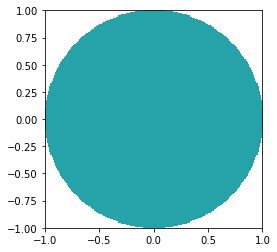

In [16]:
universe.plot(width=(2.0, 2.0))

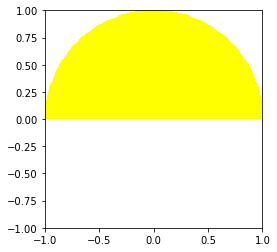

In [31]:
universe.plot(width=(2.0, 2.0), basis='xz')

universe.plot(width=(2.0, 2.0), basis='xz',
              colors={cell: 'yellow'})


In [18]:
fuel_or = openmc.ZCylinder(r=0.39)
clad_ir = openmc.ZCylinder(r=0.40)
clad_or = openmc.ZCylinder(r=0.46)
fuel_region = -fuel_or
gap_region = +fuel_or & -clad_ir
clad_region = +clad_ir & -clad_or
fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(2, 'air gap')
gap.region = gap_region

clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = clad_region
pitch = 1.26
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')
water_region = +left & -right & +bottom & -top & +clad_or

moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = water_region
box = openmc.rectangular_prism(width=pitch, height=pitch,
                               boundary_type='reflective')
type(box)
water_region = box & +clad_or
root = openmc.Universe(cells=(fuel, gap, clad, moderator))

geom = openmc.Geometry()
geom.root_universe = root

# or...
geom = openmc.Geometry(root)
geom.export_to_xml()
!cat geometry.xml



<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" name="fuel" region="-3" universe="3" />
  <cell id="2" material="void" name="air gap" region="3 -4" universe="3" />
  <cell id="3" material="2" name="clad" region="4 -5" universe="3" />
  <cell id="4" material="3" name="moderator" region="6 -7 8 -9 5" universe="3" />
  <surface coeffs="0.0 0.0 0.39" id="3" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.4" id="4" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.46" id="5" type="z-cylinder" />
  <surface boundary="reflective" coeffs="-0.63" id="6" type="x-plane" />
  <surface boundary="reflective" coeffs="0.63" id="7" type="x-plane" />
  <surface boundary="reflective" coeffs="-0.63" id="8" type="y-plane" />
  <surface boundary="reflective" coeffs="0.63" id="9" type="y-plane" />
</geometry>


/home/ashraful/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/ashraful/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


In [19]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000


In [20]:
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
  </source>
</settings>


In [21]:
cell_filter = openmc.CellFilter(fuel)

t = openmc.Tally(1)
t.filters = [cell_filter]
t.nuclides = ['U235']
t.scores = ['total', 'fission', 'absorption', '(n,gamma)']
tallies = openmc.Tallies([t])
tallies.export_to_xml()
!cat tallies.xml



<?xml version='1.0' encoding='utf-8'?>
<tallies>
  <filter id="1" type="cell">
    <bins>1</bins>
  </filter>
  <tally id="1">
    <filters>1</filters>
    <nuclides>U235</nuclides>
    <scores>total fission absorption (n,gamma)</scores>
  </tally>
</tallies>


In [22]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################